# Configuration

### Calling the functions, libraries and objects

In [1]:
from utils.libraries import *
from utils.objects import *
from utils.functions import *
from definitions import *

### Setting up the configuration

In [6]:
## Date varialbes
years = 20
period="W"
cutoff_date=datetime.today().strftime('%Y-%m-%d')
Ymd_str = datetime.today().strftime('%Y%m%d')
Ym_str = datetime.today().strftime('%Y%m')
Y_str = datetime.today().strftime('%Y')
timeframe = 365*years
today = datetime.today()
end = today.strftime("%Y-%m-%d")
start = (today - dt.timedelta(days=timeframe)).strftime("%Y-%m-%d")
periods = period

## Config varialbes
ROOT_PATH = Path(ROOT_PATH)
config_paths = [
    "config\Market_Data_Config.csv",
    "config\Economic_Data_Config.csv",
    "config\Calc_Data_Config.csv"]
market_config = ROOT_PATH.joinpath(config_paths[0])
economic_config = ROOT_PATH.joinpath(config_paths[1]).abspath()
calc_config = ROOT_PATH.joinpath(config_paths[2]).abspath()
target_list = pd.read_csv(market_config, sep=";", header=0).loc[:, "Codigo"].to_list()
markets_used = pd.read_csv(market_config, sep=";", header=0).loc[:, "Codigo"].to_list()
markets_remove = pd.read_csv(market_config, sep=";", header=0).loc[:, "Market"].to_list()
# markets_used = ['SPY', 'GDX', 'BND']
target = "Financials"
seed = 2  # ML random seed
extract = True
cross_val=5
medidas = ["mean", "median", "mode", "Min", "Percentil_25", "Percentil_75","Max", "var", "std", "skew", "kurt"]
extract = True

### Creating the necessary folders

In [7]:
## Paths variables
PARENT_DIR = "C:/Users/Joan Oliver/Documents/GitHub/Economic_Market_Forecasting/Economic_Market_Forecasting/EMF_webapp/src/"
DATA_FOLDER = "data/result/processed_data"
PREDICT_FOLDER = "data/result/prediction_data"
MODEL_FOLDER = "model"

data_path = PARENT_DIR+"/"+ DATA_FOLDER+"/"+ Y_str+"/"+ Ym_str+"/"+ Ymd_str
predict_path = PARENT_DIR+"/"+ PREDICT_FOLDER+"/"+ Y_str+"/"+ Ym_str+"/"+ Ymd_str
model_path = PARENT_DIR+"/"+ MODEL_FOLDER+"/"+ Y_str+"/"+ Ym_str+"/"+ Ymd_str
try:
    os.makedirs(data_path)
except:
    print("No folder created: "+DATA_FOLDER)
try:
    os.makedirs(predict_path)
except:
    print("No folder created: "+PREDICT_FOLDER)
try:
    os.makedirs(model_path)
except:
    print("No folder created: "+MODEL_FOLDER)

No folder created: data/result/processed_data
No folder created: data/result/prediction_data
No folder created: model


# Loading and extracting the data

### Extracting the US economic and market data

In [8]:
if extract == True:
    # Initialize the Economic Data Analyzer class
    eda = EconomicDataAnalyzer()
    # Load the Market Data
    print("> Load the market data config")
    market = eda.read_config(market_config)
    market_dict = eda.convert_to_dictionary(markets_used=markets_used)
    market_dict = market_dict['Market']
    # Load the economic data config
    print("> Load the economic data config")
    econ = eda.read_config(economic_config)
    fred_series_dict = eda.convert_to_dictionary(markets_used=None)
    fred_series_dict = fred_series_dict["Indicador"]
    calc = eda.read_config(calc_config)
    series_calc_dict = eda.convert_to_dictionary(markets_used=None)
    series_calc_dict = series_calc_dict["Indicador"]
    # Setting up the indicator dictionaries
    print("> Setting up the indicator dictionaries")
    indicators = {}
    for ind in list(econ["Tipo"].unique()):
        indicators[ind] = econ[econ["Tipo"] == ind]["Indicador"].to_list()
    if extract == True:
        # Extracting the indicator data
        print("> Extracting the indicator data")
        indicators_df = eda.indicator_extraction(fred_series_dict, series_calc_dict, root_path=ROOT_PATH)
        # Extracting the market data
        print("> Extracting the market data")
        stocks = list(market_dict.keys())
        market_df = eda.market_extraction(stocks, start, end, root_path=ROOT_PATH)
    else:
        print("No data extraction, reading data from data file")
        path = ROOT_PATH.joinpath('data', 'raw', 'indicators_df.csv')
        indicators_df = pd.read_csv(path)
        path = ROOT_PATH.joinpath('data', 'raw', 'market_df.csv')
        market_df = pd.read_csv(path)
    ### Extracting the EU economic and market data
    # ## Extracting European economic data
    # import eurostat
    # #### EU Yield Curve
    # yield_curve = eurostat.get_data_df("irt_euryld_d")
    # yld_crv = yield_curve.loc[(~yield_curve["bonds"].str.contains("AAA")) & (yield_curve["yld_curv"].str.contains("INS_FWD")) & (~yield_curve["maturity"].str.contains("M")),:]
    # yld_crv.set_index("maturity", inplace=True)
    # yld_crv["maturity_int"] = yld_crv.index.str.split("Y").str[1].astype(int)
    # yld_crv.sort_values("maturity_int",ascending=True, inplace=True)
    # yld_crv.drop(["maturity_int"], axis=1, inplace=True)
    # yld_crv = yld_crv.T
    # yld_crv = yld_crv.loc[yld_crv.index.drop(["freq",'yld_curv', 'bonds', 'geo\TIME_PERIOD'])]
    # yld_crv.index = pd.to_datetime(yld_crv.index)
    # yld_lst = []
    # for yld in yld_crv.columns:
    #     yld_lst.append(f"EU_yield_{yld}")
    # yld_crv.set_axis(yld_lst, axis=1, inplace=True)
    # intr_inds = pd.merge(indicators_df, yld_crv, left_index=True, right_index=True)
    # #### EU HICP
    # hicp = eurostat.get_data_df("PRC_HICP_MIDX")
    # hicp = hicp.loc[(hicp["geo\TIME_PERIOD"] == "EU") & (hicp["coicop"] == "CP00") & (hicp["unit"] == "I15"),:].T
    # hicp.drop(["freq", "geo\TIME_PERIOD", "coicop", "unit"], axis=0, inplace=True)
    # hicp.set_axis(["EU CPI"], axis=1, inplace=True)
    # hicp.index = pd.to_datetime(hicp.index)
    # intr_inds = pd.merge(intr_inds, hicp, left_index=True, right_index=True)
    # #### EU Government Deficit
    # gov_def = eurostat.get_data_df("GOV_10DD_EDPT1")
    # gov_def = gov_def.loc[(gov_def["geo\TIME_PERIOD"] == "EA20") & (gov_def["sector"] == "S13") & (gov_def["na_item"] == "B9") & (gov_def["unit"] == "PC_GDP"), :].T
    # gov_def.set_axis(gov_def.loc["geo\TIME_PERIOD"].values, axis=1, inplace=True)
    # gov_def.drop(["freq", "geo\TIME_PERIOD", "sector", "na_item", "unit"], axis=0, inplace=True)
    # gov_def.plot()
    # Preparing the data
    ### Data cleaning
    # Cleaning the indicator data
    print("> Cleaning the indicator data")
    df_indicators, df_indicators_cum, df_indicators_diff, df_indicators_rets, df_indicators_limpio = eda.limpiar_indicators(
        df_indicators=indicators_df, 
        indicator_dict=indicators, 
        resample=periods, 
        fill_method="ffill", 
        start=start, 
        end=end, 
        root_path=ROOT_PATH)
    # Cleaning the market data
    print("> Cleaning market data")
    df_market, df_markets_rets, df_markets_cum, df_markets_diff  = eda.limpiar_markets(
        markets_dict=market_dict,
        df_markets=market_df,
        resample=periods, 
        fill_method="ffill", 
        start=start, 
        end=end, 
        root_path=ROOT_PATH)
    ### Merge indicator and market data
    list_market_dfs = [df_market,df_markets_rets,df_markets_cum,df_markets_diff]
    list_indicators_dfs = [df_indicators_limpio,df_indicators_rets,df_indicators_cum,df_indicators_diff]

    df_all_data, df_all_data_rets, df_all_data_cum, df_all_data_diff = eda.merge_data(list_market_dfs, list_indicators_dfs, root_path=ROOT_PATH)
    ### Feature Engineering
    ### Remove Outliers 
    df = eda.remove_outliers(df_all_data_rets)
    ### Adding features
    df_all_data["CAPE Ratio"] = df_all_data["SP500"]/(df_all_data["Corporate Profits"]*0.01)
    df["CAPE Ratio"] = df_all_data["SP500"]/(df_all_data["Corporate Profits"]*0.01)

    # df_all_data["CAPE Ratio"].plot()
    def trend_line(df, name, deg=2):
        coef = np.polyfit(range(0,len(df[name])), df[name], deg)
        x_trend = np.linspace(0,len(df[name]),len(df[name]))
        y_trend = np.polyval(coef, x_trend)
        df = pd.DataFrame(y_trend, index=df.index, columns=[name])
        return df

    # df_all_data = pd.DataFrame()
    df_all_data["SP_GDP"] = df_all_data["SP500"]/(df_all_data["GDP"]*.01)
    df_all_data["SP_GDP_trend"] = trend_line(df_all_data, "SP_GDP", deg=5)
    df["SP_GDP"] = df_all_data["SP500"]/(df_all_data["GDP"]*.01)
    df["SP_GDP_trend"] = trend_line(df_all_data, "SP_GDP", deg=5)

    # df_all_data = pd.DataFrame()
    std = df_all_data["SP_GDP"].std()
    df_all_data["SP_GDP_1std"] = df_all_data["SP_GDP_trend"] + (std)
    df["SP_GDP_1std"] = df_all_data["SP_GDP_trend"] + (std)

    # df_all_data = df_all_data.copy()
    # df_ts = df_all_data.loc[:,df_all_data.columns.str.contains(f"t-")]
    # df_all_data.drop(df_ts.columns,axis=1,inplace=True)
    for ma in df_all_data.columns:
        df_all_data[f"{ma}_MA"] = df_all_data[[ma]].rolling(window=52).mean().fillna(method="ffill").fillna(method="bfill")
        df_all_data[f"{ma}_std"] = df_all_data[[ma]].rolling(window=52).std().fillna(method="ffill").fillna(method="bfill")
        df_all_data[f"{ma}_trend"] = trend_line(df_all_data[[ma]], ma, deg=6)
        df_all_data[f"{ma}_MA_trend_dif"] = df_all_data[f"{ma}_trend"] - df_all_data[f"{ma}_MA"]
        
        df[f"{ma}_MA"] = df_all_data[[ma]].rolling(window=52).mean().fillna(method="ffill").fillna(method="bfill")
        df[f"{ma}_trend"] = trend_line(df_all_data[[ma]], ma, deg=6)
        df[f"{ma}_MA_trend_dif"] = df_all_data[f"{ma}_trend"] - df_all_data[f"{ma}_MA"]
    ### Creating lags in the data
    list_data_dfs = [df_all_data,df_all_data_rets,df_all_data_cum,df_all_data_diff]

    df_all_lag_data, df_all_lag_data_rets, df_all_lag_data_cum, df_all_lag_data_diff = eda.lag_data(list_data_dfs, target, n_lags=24)
    df = eda.remove_outliers(df_all_lag_data_rets)
    for mkt in markets_remove:
        if mkt == target:
            pass
        else:
            for df_col in df.columns:
                if mkt in df_col:
                    try:
                        df.drop(df_col, axis=1, inplace=True)
                    except:
                        pass
    ### Feature Reduction
    ## Data Preprocessing
    econ_ml = Preprocessor()
    ### Feature Reduction
    #### Feature selection by correlation
    df_feat_corr = pd.DataFrame(df.corr().loc[target,:].sort_values(ascending=False))
    df_feat_relevant_corr = df_feat_corr[(df_feat_corr[target]>0.05) | (df_feat_corr[target]<-0.05)]
    df_feat_relevant_corr
    #### Indentifying the most important features
    ##### Splitting the data

    ##### Creating the baseline for feature importance
    baseline_models = econ_ml.define_baseline_models()

    X_train, X_test, y_train, y_test = econ_ml.train_test_split_data(data=df, target_col=target, test_size=0.15)
    model_results, baseline_preds, best_model, best_model_name = econ_ml.baseline_ml(target, X_train, X_test, y_train, y_test, baseline_models)

    print("> Performing feature importance analysis")
    df_top_data, feature_importance, top_feature_importance, score = econ_ml.feature_importance(target=target, 
                                                                                                    df_data=df.loc[:cutoff_date],
                                                                                                    model=best_model,
                                                                                                    accepted_importance=0.85)
    #### Feature removal
    def feature_removal(df, df_top_data, model_results, best_model_name, score):
        best_model_score = model_results.loc[best_model_name,"score"]
        if score > best_model_score*.9:
            print("We choose to remove "+str(len(df.columns)-len(df_top_data.columns))+" features")
            df = df_top_data.copy()
        else:
            print("We choose to keep the original df with "+str(len(df_top_data.columns))+" features")
        return df

    df = feature_removal(df, df_top_data, model_results, best_model_name, score)
    ## Saving the processed data (ready for ML)
    df.to_csv(data_path+f"/processed_data_{target}_{Ymd_str}.csv", index=True, index_label="Date")

else:
    ## Reading the processed data
    df = pd.read_csv(data_path+f"/processed_data_{target}_{Ymd_str}.csv", index_col="Date")

> Load the market data config
> Load the economic data config
> Setting up the indicator dictionaries
> Extracting the indicator data
   -->Extracting 10-Year Treasury Yield...
   -->Extracting 2-Year Treasury Yield...
   -->Extracting Federal Funds Effective Rate...
   -->Extracting 1-Month Treasury Yield...
   -->Extracting 3-Month Treasury Yield...
   -->Extracting 5-Year Treasury Yield...
   -->Extracting 20-Year Treasury Yield...
   -->Extracting 30-Year Treasury Yield...
   -->Extracting 15-Year Mortgage Rate...
   -->Extracting 30-Year Mortgage Rate...
   -->Extracting 10-Year Euro Gov Bond Yield...
   -->Extracting 3-Month Euro Gov Bond Yield...
   -->Extracting 3-Month China Gov Bond Yield...
   -->Extracting 10-Year India Gov Bond Yield...
   -->Extracting CPI...
   -->Extracting PPI...
   -->Extracting China CPI...
   -->Extracting Europe CPI...
   -->Extracting Unemployment Rate...
   -->Extracting GDP...
   -->Extracting Real GDP...
   -->Extracting Consumer Confidence Ind

In [13]:
df = pd.read_csv(r"C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\src\data\result\processed_data\2023\202308\20230814\processed_data_Financials_20230814.csv", index_col="Date")

# Performing Machine Learning

### Pick the best model

In [ ]:
## Data Preprocessing
econ_ml = Preprocessor()
X_train, X_test, y_train, y_test = econ_ml.train_test_split_data(data=df, target_col=target, test_size=0.15)
model_results, baseline_preds, best_model, best_model_name = econ_ml.baseline_ml(target, X_train, X_test, y_train, y_test, baseline_models)

In [ ]:
### Define the grids
params_RandomForest = {
    "n_estimators": [120],
    "max_depth": [10,15,17],
    "max_features": ["sqrt", 3, 4]                          
    }

params_GradientBoosting = {
    'n_estimators': [100, 150],  # 50, 
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [5, 7],  
    }

params_XGBRegressor = {
    'n_estimators': [150, 250],  # 100
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [ 5, 7, 11],
    # 'subsample': [0.8, 1.0],
    # 'max_leaf_nodes': [32, 64, 108]
    }

params_KNeighborsRegressor = {
    'n_neighbors': [3, 5, 7, 9],  
    'weights': ['uniform', 'distance'],  
    'p': [1, 2],  
    }

params_SVR = {
    'C': [0.1, 1.0, 10.0],  
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'degree': [2, 3, 4],  
    'gamma': ['scale', 'auto', 0.1, 1.0],  
    }

baseline_params = {
    "RandomForest":params_RandomForest,
    "GradientBoosting":params_GradientBoosting,
    "SVR":params_SVR,
    "KNeighborsRegressor":params_KNeighborsRegressor,
    "XGBRegressor":params_XGBRegressor
}
def model_gridSearch(baseline_models,baseline_params,model_results,X_train,y_train,X_test,y_test,cross_val=5):
    y_test = y_test.copy()
    models_gridsearch = {}
    for name, model in baseline_models.items():
        if name in model_results.index.values:
            for mod,params in baseline_params.items():
                if name == mod:
                    models_gridsearch[mod] = GridSearchCV(model, params, cv=cross_val, scoring="neg_root_mean_squared_error", verbose=1, n_jobs=1)
                    models_gridsearch[mod].fit(X_train, y_train)
    best_grids = [(i, j.best_score_) for i, j in models_gridsearch.items()]
    best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
    top_model = models_gridsearch[best_grids.loc[0,"Grid"]]
    return models_gridsearch, best_grids, top_model

### Performing Grid Search

In [ ]:
models_gridsearch, best_grids, top_model = model_gridSearch(baseline_models,baseline_params,model_results,X_train,y_train,X_test,y_test,cross_val=cross_val)

In [ ]:
dump(top_model, model_path+f"\{target}_best_model.joblib")

# Performing Deep Neural Network

In [31]:
def scale_datasets(x_train, x_test):

  """
  Standard Scale test and train data
  Z - Score normalization
  """
  standard_scaler = StandardScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled
econ_ml = Preprocessor()
X_train, X_test, y_train, y_test = econ_ml.train_test_split_data(data=df, target_col=target, test_size=0.15)
# X_train_scaled, X_test_scaled = scale_datasets(X_train, X_test)

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)


In [63]:
def create_model(layers, activation, optimizer, loss, metrics):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i == 0:
            model.add(Dense(nodes, input_dim=X_train_scaled.shape[1], activation=activation))
            model.add(Dropout(0.5))
        else:
            model.add(Dense(nodes, activation=activation))
            model.add(Dropout(0.5))
    model.add(Dense(1))

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)

In [64]:
layers = [[64],[64, 32],[64, 128, 32], [64, 128, 256, 256, 128, 64]]
activations = ['relu', 'sigmoid','tanh']
optimizers = ['adam']
losses = ['root_mean_squared_error']
metrics = ['root_mean_squared_error']
batch_size = [32, 64, 128]
epochs = [10, 15, 20, 30]
param_grid = dict(layers=layers, activation=activations, optimizer=optimizers, loss=losses, metrics=metrics,  batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

In [65]:
grid_results = grid.fit(X_train_scaled, y_train)

ValueError: in user code:

    File "c:\Users\Joan Oliver\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Joan Oliver\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Joan Oliver\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Joan Oliver\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Joan Oliver\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1083, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses
    File "c:\Users\Joan Oliver\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\compile_utils.py", line 240, in __call__
        self.build(y_pred)
    File "c:\Users\Joan Oliver\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\compile_utils.py", line 183, in build
        self._get_loss_object, self._losses
    File "c:\Users\Joan Oliver\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\compile_utils.py", line 353, in _get_loss_object
        loss = losses_mod.get(loss)
    File "c:\Users\Joan Oliver\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\losses.py", line 2663, in get
        return deserialize(identifier)
    File "c:\Users\Joan Oliver\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\losses.py", line 2621, in deserialize
        printable_module_name="loss function",
    File "c:\Users\Joan Oliver\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\saving\legacy\serialization.py", line 558, in deserialize_keras_object
        f"Unknown {printable_module_name}: '{object_name}'. "

    ValueError: Unknown loss function: 'rmse'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


In [ ]:
grid_results.best_params_

{'activation': 'sigmoid',
 'batch_size': 32,
 'epochs': 20,
 'layers': [128, 256, 128, 64],
 'loss': 'mse',
 'metrics': 'mse',
 'optimizer': 'adam'}

In [ ]:
pred_y = grid.predict(X_test_scaled)

In [ ]:
mean_squared_error(y_test, pred_y)

0.0007552966669146764

<AxesSubplot:xlabel='Date'>

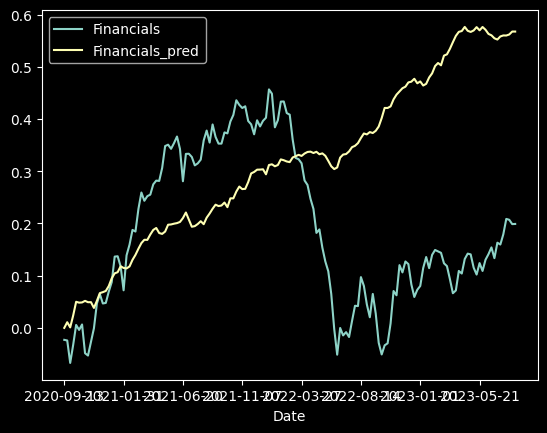

In [ ]:
prediction = pd.DataFrame({f"{target}":y_test, f"{target}_pred":(pred_y-pred_y[0])*100})
prediction.cumsum().plot()

In [72]:
import psycopg2

table_df = df.copy()
table_df.columns = [col.replace(" ", "_").replace("-", "_").replace("(", "").replace(")", "") for col in table_df.columns]
table_name = f"{target}_data"


conn = psycopg2.connect(
    host="localhost",
    database="postgres",
    user="postgres",
    password="CFALevel12018",
    port=5432
)
cur = conn.cursor()

cur.execute(f"""CREATE TABLE IF NOT EXISTS {table_name} (
        date CHAR PRIMARY KEY
);
""")

for col in table_df:
    try:
        cur.execute(
            f"""
            ALTER TABLE {table_name}
            ADD COLUMN col_{col} FLOAT;
            """
        )
    except:
        pass

conn.commit()
# cur.close()
# conn.close()

In [79]:
def check_date_exists(cur, date, table_name):
    query = (f"""SELECT date FROM {table_name} date = %s;""")
    cur.execute(query, (date,))
    return cur.fetchone() is not None
def update_row(i, cur, table_name):
    for col in table_df.columns:
        query = (f"""UPDATE {table_name} SET {col} = %s WHERE date = %s;""")
        cur.execute(query, (table_df["Date"][i],))
        conn.commit()
def insert_row(row, cols, s_str, table_name):
    query = (f"""INSERT INTO {table_name} ({cols})VALUES ({s_str});""")
    cur.execute(query, (row.name,))
    conn.commit()

In [86]:
for i, row in table_df.iterrows():
    print(row.name)
    print(cols)
    insert_row(row, cols, s_str, table_name)

2004-02-15
10_Year_Treasury_Yield, 2_Year_Treasury_Yield, 5_Year_Treasury_Yield, 20_Year_Treasury_Yield, 30_Year_Treasury_Yield, 15_Year_Mortgage_Rate, 30_Year_Mortgage_Rate, US_Dollar_Index, VIX, 3m5y, 3m10y, 2y10y, 10yTrea30yFRM, 10_Year_Treasury_Yield_t_1, 10_Year_Treasury_Yield_t_2, 10_Year_Treasury_Yield_t_3, 10_Year_Treasury_Yield_t_4, 10_Year_Treasury_Yield_t_5, 10_Year_Treasury_Yield_t_6, 10_Year_Treasury_Yield_t_7, 10_Year_Treasury_Yield_t_8, 10_Year_Treasury_Yield_t_9, 10_Year_Treasury_Yield_t_10, 10_Year_Treasury_Yield_t_11, 10_Year_Treasury_Yield_t_12, 10_Year_Treasury_Yield_t_13, 10_Year_Treasury_Yield_t_14, 10_Year_Treasury_Yield_t_15, 10_Year_Treasury_Yield_t_16, 10_Year_Treasury_Yield_t_17, 10_Year_Treasury_Yield_t_18, 10_Year_Treasury_Yield_t_19, 10_Year_Treasury_Yield_t_20, 10_Year_Treasury_Yield_t_21, 10_Year_Treasury_Yield_t_22, 10_Year_Treasury_Yield_t_23, 10_Year_Treasury_Yield_t_24, 2_Year_Treasury_Yield_t_2, 2_Year_Treasury_Yield_t_3, 2_Year_Treasury_Yield_t_4, 

IndexError: tuple index out of range

In [74]:
s_list = []
for col in df.columns:
    s_list.append(f"%s")
s_str = ", ".join(s_list)

In [75]:
cols = ", ".join(df.columns)

In [77]:
tmp_df = pd.DataFrame(columns=table_df.columns)
cols = ", ".join(table_df.columns)
s_list = []
for col in df.columns:
    s_list.append(f"%s")
s_str = ", ".join(s_list)

cur = conn.cursor()
for i, row in table_df.iterrows():
    if check_date_exists(cur, row.name, table_name):
        update_row(i, cur, table_name)
    else:
        tmp_df = tmp_df.append(row)
        insert_row(row, cols, s_str, table_name)
    # print(row)

SyntaxError: error de sintaxis en o cerca de «=»
LINE 1: SELECT date FROM Financials_data date = '2004-02-15';
                                              ^


In [33]:
def lstm_model(epochs,batch_size,validation_split):
    # LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=160, return_sequences=True, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
    lstm_model.add(LSTM(units=480, return_sequences=True, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
    lstm_model.add(LSTM(256))
    lstm_model.add(Dense(units=1))
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    return lstm_model

def gru_model(epochs,batch_size,validation_split):
    # gru model
    gru_model = Sequential()
    gru_model.add(GRU(units=64, return_sequences=True, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
    gru_model.add(GRU(32))
    gru_model.add(Dense(units=1))
    gru_model.compile(optimizer='adam', loss='mse')
    gru_model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    return gru_model

def cnn_model(epochs,batch_size,validation_split):
    # cnn model
    cnn_model = Sequential()
    cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(units=1))
    cnn_model.compile(optimizer='adam', loss='mse')
    cnn_model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    return cnn_model

In [34]:
models = {
    "LSTM":lstm_model(epochs=15,batch_size=64,validation_split=0.2),
    # "GRU":gru_model(epochs=15,batch_size=16,validation_split=0.2),
    # "CNN":cnn_model(epochs=15,batch_size=16,validation_split=0.2)
}

Epoch 1/15
11/11 [==============================] - 185s 17s/step - loss: 0.0013 - val_loss: 6.9610e-04
Epoch 2/15
11/11 [==============================] - 209s 19s/step - loss: 5.7139e-04 - val_loss: 6.8685e-04
Epoch 3/15
11/11 [==============================] - 217s 20s/step - loss: 5.5462e-04 - val_loss: 6.8789e-04
Epoch 4/15
11/11 [==============================] - 218s 20s/step - loss: 5.5553e-04 - val_loss: 6.8675e-04
Epoch 5/15
11/11 [==============================] - 215s 20s/step - loss: 5.5868e-04 - val_loss: 6.8716e-04
Epoch 6/15
11/11 [==============================] - 219s 20s/step - loss: 5.5171e-04 - val_loss: 6.8588e-04
Epoch 7/15
11/11 [==============================] - 222s 20s/step - loss: 5.5023e-04 - val_loss: 6.8658e-04
Epoch 8/15
11/11 [==============================] - 223s 20s/step - loss: 5.5208e-04 - val_loss: 6.8659e-04
Epoch 9/15
11/11 [==============================] - 225s 21s/step - loss: 5.5106e-04 - val_loss: 6.8793e-04
Epoch 10/15
11/11 [=============

In [35]:
models['LSTM'].summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 335, 160)          103680    
                                                                 
 lstm_12 (LSTM)              (None, 335, 480)          1230720   
                                                                 
 lstm_13 (LSTM)              (None, 256)               754688    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,089,345
Trainable params: 2,089,345
Non-trainable params: 0
_________________________________________________________________


In [36]:
model_eval = {}
for name, model in models.items():
    if name != "CNN":
        loss_score = model.evaluate(X_test, y_test)
        print(f"Evaluate the model: {name}: {loss_score}")
        model_eval[name] = loss_score
    # model.evaluate(X_test, y_test)
model_eval_df = pd.DataFrame(model_eval.values(), index=model_eval.keys()).sort_values(by=0, ascending=True)

5/5 [==============================] - 5s 1s/step - loss: 7.5358e-04
Evaluate the model: LSTM: 0.0007535847253166139


In [52]:
pred = pd.DataFrame(models["LSTM"].predict(X_test), index=y_test.index)*100
pred_vol = (pred-pred.iloc[-1].values)*100

5/5 [==============================] - 7s 1s/step


In [55]:
print(pred_vol.std())
print(y_test.std())

0    0.086909
dtype: float32
0.027514172859890378


In [ ]:
((X_test.prediction*100)-0.17).cumsum().plot()
y_test.cumsum().plot()

In [ ]:
for name, model in models.items():
    if name != "CNN":
        print(f"Review of model: {name}")
        try:
            df_history = pd.DataFrame({"Loss":model.history.history['loss'], "Val_Loss":model.history.history['val_loss']})
            df_history.plot(figsize=(10, 6), title=name)
        except:
            pass
        pred = model.predict(X_test)
        predictions = pd.DataFrame(pred, index=y_test.index)
        predictions.index = pd.to_datetime(predictions.index)
        predictions.columns = [target+"_Pred"]

        model.save(f'models\models\{name}_best_model.h5')
        model.save_weights(f'models\weights\{name}_best_model.h5') 

        y_test.index = pd.to_datetime(y_test.index)
        EMF_forecast = pd.concat([y_test, predictions], axis=1).cumsum()
        # print(model.summary())
        plt.figure(figsize=(10, 6))
        plt.title(f"{name} -> {X_test.index[0]} - {X_test.index[-1]}")
        plt.plot(EMF_forecast, label=EMF_forecast.columns)
        plt.legend()
model_eval_df.columns = ["mse"]
model_eval_df["rmse"] = np.sqrt(model_eval_df["mse"])
all_model_results = pd.concat([model_eval_df,model_results], axis=0).sort_values(by='rmse', ascending=True)
best_model = all_model_results.iloc[0]
if name == best_model.name:
    EMF_forecast.to_csv(prediction_path+f"/EMF_forecast_{target}.csv")

# Forecasting Indicator Performance

### Monte Carlo Simulation

In [ ]:
# Calculating the stats
mean = df.mean()
var = df.var()
drift = mean - (.5 * var)
std = df.std()

# Setting the Monte Carlo Varuables
ind = 0
T = 104
num_ports = 100
date_range = pd.date_range(start=cutoff_date, periods=T, freq="W")

dict_future = {}
df_mean_future = pd.DataFrame(index=pd.date_range(start=cutoff_date, periods=T, freq="W"))
df_max_future = pd.DataFrame(index=pd.date_range(start=cutoff_date, periods=T, freq="W"))
df_min_future = pd.DataFrame(index=pd.date_range(start=cutoff_date, periods=T, freq="W"))

# Running through indicator columns to forecast
for ind, col in enumerate(df.columns):
    # Calculating the Weekly Returns
    weekly_rets = np.exp(drift.values[ind] + std.values[ind] * norm.ppf(np.random.rand(T, num_ports)))

    # Getting the most current weekly return (run it back if it's too small)
    n = -1
    S0 = 0
    while (S0 < 0.01) and (S0 > -0.01):
        S0 = df.cumsum().iloc[n,ind]
        n = n - 1
    # Creating the empty list and filling the first row
    price_list = np.zeros_like(weekly_rets)
    price_list[0] = S0

    # Performing Monte Carlo Situlation a 'num_ports' number of times
    for t in range(1,T):
        price_list[t] = price_list[t-1] * weekly_rets[t]
        dict_future[col] = pd.DataFrame(price_list,index=date_range)

### Working on the forecast data

##### Creating a list of forecasted futures

In [ ]:
### Each item is a dataframe of a possible future of all indicators

list_futures = []
for n in range(0,num_ports):
    globals()["df_future_"+str(n)] = pd.DataFrame()
    for indicator in dict_future.keys():
        globals()["df_future_"+str(n)][indicator] = dict_future[indicator][n]
    list_futures.append(globals()["df_future_"+str(n)])

In [ ]:
## Define a custom merging function
# def merge_columns_with_nans(row):
#     merged_values = []
#     for value in row:
#         if pd.notna(value):
#             merged_values.append(value)
#     return merged_values

##### Merging the forecasted data with the historical data

In [ ]:
df.index = pd.to_datetime(df.index)
list_present_future = []
for n,future in enumerate(list_futures):
    globals()["df_future_"+str(n)].index = pd.to_datetime(globals()["df_future_"+str(n)].index)
    df_presentVSfuture = pd.concat([df,globals()["df_future_"+str(n)].pct_change()], axis=1, join="outer")
    globals()["df_present_future_"+str(n)] = pd.DataFrame()
    for col in df_presentVSfuture.columns:
        # df1 = df_presentVSfuture[[col]].apply(merge_columns_with_nans, axis=1).apply(pd.Series)
        # globals()["df_present_future_"+str(n)][col] = df1
        globals()["df_present_future_"+str(n)][col] = df_presentVSfuture[col].fillna(0).iloc[:,0] + df_presentVSfuture[col].fillna(0).iloc[:,1]
    list_present_future.append(globals()["df_present_future_"+str(n)])

In [ ]:
def best_prediction(models_gridsearch, best_grids, top_model, X_test, y_test):
    y_pred = models_gridsearch[best_grids.loc[0,"Grid"]].predict(X_test)
    y_pred = pd.DataFrame(y_pred, columns=[target+"_Prediction"],index=y_test.index)
    y_pred.index, y_test.index = pd.to_datetime(y_test.index), pd.to_datetime(y_test.index)
    model_pred = pd.concat([y_test, y_pred], axis=1)
    return y_pred, y_test, model_pred

In [ ]:
df_prediction = df[[target]].cumsum()
list_prediction = [df_prediction]
for n, present_future in enumerate(list_present_future):
    df_pred = present_future.fillna(method="ffill")

    test_size = T/len(df_pred)

    X_train, X_test, y_train, y_test = econ_ml.train_test_split_data(data=df_pred, target_col=target, test_size=test_size)
    # model_results, baseline_preds, best_model, best_model_name = econ_ml.baseline_ml(target, X_train, X_test, y_train, y_test, baseline_models)
    y_pred = top_model.predict(X_test)
    y_pred = pd.DataFrame(y_pred, columns=[target+"_Prediction"],index=y_test.index)
    y_pred.index, y_test.index = pd.to_datetime(y_test.index), pd.to_datetime(y_test.index)
    model_pred = pd.concat([y_test, y_pred], axis=1)
    model_pred.columns = [target+"_"+str(n),target+"_Prediction"+"_"+str(n)]
    latest_actual = df[[target]].cumsum().loc[df.index[-1]].values[0]
    model_pred = model_pred.cumsum()+latest_actual
    # df_prediction[target+"_"+str(n)] = model_pred[target+"_"+str(n)]
    # df_prediction[target+"_Prediction_"+str(n)] = model_pred[target+"_Prediction_"+str(n)]
    # df_prediction = pd.concat([df[target].cumsum(),model_pred.cumsum()+latest_actual], axis=1)
    list_prediction.append(model_pred)
df_all_predictions = pd.concat(list_prediction,axis=1)

In [ ]:
df_all_predictions.to_csv(predict_path+f"\prediction_{target}_{Ymd_str}.csv", index=True, index_label="Date")

In [ ]:
df_all_predictions.plot(figsize=(20,8), legend=False, grid=True)
# df_all_predictions

In [ ]:
df_future_preds = (df_all_predictions.loc[:,df_all_predictions.columns.str.contains("Prediction")]-latest_actual).dropna()
for n in np.linspace(0,1,5):
    print(round(n,2))
    df_future_preds.quantile(round(n,2),axis=1).plot(figsize=(20,8), legend=False, grid=True)

In [ ]:
df_all_predictions.loc[:,df_all_predictions.columns.str.contains("_")].plot()

In [ ]:
pd.conco((df_all_predictions.loc[:,df_all_predictions.columns.str.contains("Prediction")]))

In [ ]:
df1 = pd.read_csv(r"C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\src\data\result\prediction_data\prediction_SP500_20230812.csv", 
                    index_col="Date")
df2 = pd.read_csv(r"C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\src\data\result\prediction_data\prediction_Gold_20230812.csv", 
                    index_col="Date")
df3 = pd.read_csv(r"C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\src\data\result\prediction_data\prediction_CorporateBonds_20230812.csv", 
                    index_col="Date")

In [ ]:
df1

In [ ]:
df_future_preds = (df1.loc[:,df1.columns.str.contains("Prediction")]-latest_actual).dropna()
for n in np.linspace(0,1,5):
    print(round(n,2))
    df_future_preds.quantile(round(n,2),axis=1).plot(figsize=(20,8), legend=False, grid=True)

# Testing

In [ ]:
for present_future in list_present_future:
    test_size = T/len(present_future)
    X_train, X_test, y_train, y_test = econ_ml.train_test_split_data(data=present_future, target_col=target, test_size=test_size)
    model_results, baseline_preds, best_model, best_model_name = econ_ml.baseline_ml(target, X_train, X_test, y_train, y_test, baseline_models)


In [ ]:
df = df_future_mean.fillna(method="ffill")

In [ ]:
## Performing Machine Learning
### Pick the best model

test_size = T/len(df)

X_train, X_test, y_train, y_test = econ_ml.train_test_split_data(data=df, target_col=target, test_size=test_size)
model_results, baseline_preds, best_model, best_model_name = econ_ml.baseline_ml(target, X_train, X_test, y_train, y_test, baseline_models)

In [ ]:
### Define the grids
params_RandomForest = {
    "n_estimators": [120],
    "max_depth": [10,15,17],
    "max_features": ["sqrt", 3, 4]                          
    }

params_GradientBoosting = {
    'n_estimators': [50, 100, 150],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [3, 5, 7],  
    }

params_XGBRegressor = {
    'n_estimators': [100, 150, 250],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [ 5, 7, 11],
    # 'subsample': [0.8, 1.0],
    # 'max_leaf_nodes': [32, 64, 108]
    }

params_KNeighborsRegressor = {
    'n_neighbors': [3, 5, 7, 9],  
    'weights': ['uniform', 'distance'],  
    'p': [1, 2],  
    }

params_SVR = {
    'C': [0.1, 1.0, 10.0],  
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'degree': [2, 3, 4],  
    'gamma': ['scale', 'auto', 0.1, 1.0],  
    }

baseline_params = {
    "RandomForest":params_RandomForest,
    "GradientBoosting":params_GradientBoosting,
    "SVR":params_SVR,
    "KNeighborsRegressor":params_KNeighborsRegressor,
    "XGBRegressor":params_XGBRegressor
}
def model_gridSearch(baseline_models,baseline_params,model_results,X_train,y_train,X_test,y_test,cross_val=5):
    y_test = y_test.copy()
    models_gridsearch = {}
    for name, model in baseline_models.items():
        if name in model_results.index.values:
            for mod,params in baseline_params.items():
                if name == mod:
                    models_gridsearch[mod] = GridSearchCV(model, params, cv=cross_val, scoring="neg_root_mean_squared_error", verbose=1, n_jobs=1)
                    models_gridsearch[mod].fit(X_train, y_train)
    best_grids = [(i, j.best_score_) for i, j in models_gridsearch.items()]
    best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
    top_model = models_gridsearch[best_grids.loc[0,"Grid"]]
    return models_gridsearch, best_grids, top_model

def best_prediction(models_gridsearch, best_grids, top_model, X_test, y_test):
    y_pred = models_gridsearch[best_grids.loc[0,"Grid"]].predict(X_test)
    y_pred = pd.DataFrame(y_pred, columns=[target+"_Prediction"],index=y_test.index)
    y_pred.index, y_test.index = pd.to_datetime(y_test.index), pd.to_datetime(y_test.index)
    model_pred = pd.concat([y_test, y_pred], axis=1)
    return y_pred, y_test, model_pred

In [ ]:
print("> Performing Machine Learning")
print(">>> Performing Grid Search")
models_gridsearch, best_grids, top_model = model_gridSearch(baseline_models,baseline_params,model_results,X_train,y_train,X_test,y_test,cross_val=cross_val)

In [ ]:
dict_future.keys()

In [ ]:
print(">>> Performing Prediction")
for indicator in dict_future.keys():
    y_pred, y_test, model_pred = best_prediction(models_gridsearch, best_grids, top_model, X_test, y_test)

In [ ]:
# Find the 50th percentile of the monte carlo simulations
dict_future["SP500"].reindex(dict_future["SP500"].iloc[-1].sort_values(ascending=False).index, axis=1).iloc[:,int(num_ports/2)]

In [ ]:
try:
    X_test.index = pd.to_datetime(X_test.index)
except:
    pass
full_test = pd.concat([model_pred, X_test], axis=1)
print(">>> Saving the best model and the data")
# Save the best model
dump(top_model, r'C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\src\model'+f"\{target}_best_model.joblib")
# Save the data
model_pred.to_csv(data_path+f"\{target}_data.csv")

In [ ]:
latest_actual = df[[target]].cumsum().loc[model_pred.index[0]].values[0]
pd.concat([df[target].cumsum(),model_pred.cumsum()+latest_actual], axis=1).plot()

In [ ]:
df_max = df_future_max.fillna(method="ffill")
## Performing Machine Learning
### Pick the best model

test_size = T/len(df_max)

X_train, X_test, y_train, y_test = econ_ml.train_test_split_data(data=df_max, target_col=target, test_size=test_size)
model_results, baseline_preds, best_model, best_model_name = econ_ml.baseline_ml(target, X_train, X_test, y_train, y_test, baseline_models)

In [ ]:
y_pred = models_gridsearch[best_grids.loc[0,"Grid"]].predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=[target+"_Prediction"],index=y_test.index)
y_pred.index, y_test.index = pd.to_datetime(y_test.index), pd.to_datetime(y_test.index)
model_pred_max = pd.concat([y_test, y_pred], axis=1)
latest_actual = df[[target]].cumsum().loc[model_pred_max.index[0]].values[0]
df_max_prediction = pd.concat([df[target].cumsum(),model_pred_max.cumsum()+latest_actual], axis=1)
df_max_prediction.plot()

In [ ]:
df_min = df_future_min.fillna(method="ffill")

test_size = T/len(df_min)

X_train, X_test, y_train, y_test = econ_ml.train_test_split_data(data=df_min, target_col=target, test_size=test_size)
model_results, baseline_preds, best_model, best_model_name = econ_ml.baseline_ml(target, X_train, X_test, y_train, y_test, baseline_models)
y_pred = models_gridsearch[best_grids.loc[0,"Grid"]].predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=[target+"_Prediction"],index=y_test.index)
y_pred.index, y_test.index = pd.to_datetime(y_test.index), pd.to_datetime(y_test.index)
model_pred_min = pd.concat([y_test, y_pred], axis=1)
latest_actual = df[[target]].cumsum().loc[model_pred_min.index[0]].values[0]

df_min_prediction = pd.concat([df[target].cumsum(),model_pred_min.cumsum()+latest_actual], axis=1)
df_min_prediction.plot()